# $\underline{\textbf{Digits recognition i redes neuronales convolucionales.}}$

## $\textbf{Bastien Zimmermann}$                        
$\textit{last modification : 06/12/2019}$

---
Este notebook intenta resolver el famoso Kaggle Challenge : Digit Recognition usando scikit learn dataset hand written dataset. Al mismo tiempo desmuestra como usar computer vision para industria monstrando su foncionamiento.

challenge link : https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation

---

# Introduction

Visión por computadora, comprensión de imágenes digitales y extracción de datos de alta dimensión del mundo real para obtener información numérica o simbólica. Este campo floreció junto con la inteligencia artificial, con sistemas capaces de abordar los límites de decisión de alta dimensión (redes neuronales) desbloqueó el potencial del reconocimiento de imágenes. Imágenes y su contenido tienen muchos grados de variación: rotación, orientación, escala, iluminación, calidad y muchos otros. Cuando se trata de reconocimiento escrito a mano, un sistema se eleva por encima de los demás, esa es la Red Neural Convolucional o CNN. Esta red es un sistema de dos partes que primero identifica las características relevantes que luego se envían a un sistema neuronal. red que se cobrará por clasificar la muestra. En general, tenemos una red muy adaptable que es resistente a muchos variaciones como: escala, rotaciones o variación de ancho de trazo. 

Sin embargo, como muchos problemas de aprendizaje automático, un factor clave es primordial para que sea exitoso: tener MUCHOS datos.

El algoritmo aprende de manera similar a una red neuronal convencional usando propagación hacia atrás y descenso de gradiente a través de todas sus capas Con un buen ajuste de parámetros y una enorme cantidad de datos, la red podría aprender y alcanzar el pico actuaciones, en el trabajo inicial de Y. ¡La precisión de LeCun alcanza más del 99,2%! 
Además, este sistema es fácilmente modificable, enfrentando un problema similar, uno podría usar las mismas herramientas y un sistema modificado. arquitectura para resolverlo. En la visión por computadora, la red debe adaptarse al problema. 

Por lo tanto, disponemos de un sistema muy potente y eficiente, una vez entrenado, inferir un número de una imagen es casi sin costo ya que solo necesitamos pasar la imagen a través de la red una vez. Entonces podemos aplicarlo a problemas de gran escala reconociendo millones de números cada día.

---


### Import libraries :

In [1]:
import time, copy, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from tqdm import tqdm

In [2]:
dataset = pd.read_csv('./data/train.csv',dtype = np.float32)
#test = pd.read_csv('./test.csv')

## Observemos los datos

_Ahora miremos a como estan los datos:_

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: float32(785)
memory usage: 125.8 MB


Podemos ver que tenemos una gran quantidad de datos.

In [7]:
dataset.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cada imagen es una linea de pixels, ademas tenemos para cada imagen el label que nos indica que numero es.

Aca vemos un ejemblo dubujado.

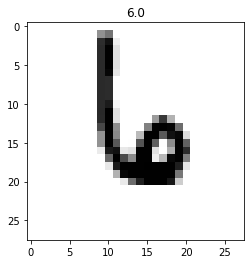

In [5]:
def showImage(df, index):
    #image = df.iloc[index]
    image = dataset.iloc[index][1:].values.reshape(28,28)
    plt.imshow(image,cmap='Greys')
    plt.title(dataset['label'].iloc[index])
showImage(dataset, 123)

An example of the digits we can find :


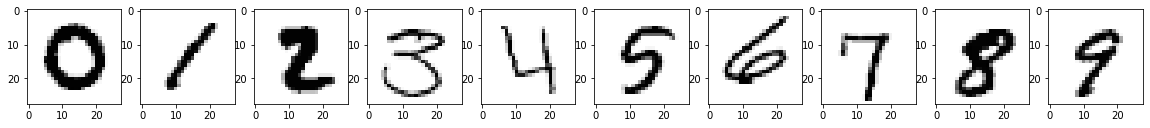

In [6]:
fig, ax = plt.subplots(ncols = 10,nrows =1, figsize = [20,5])
print('An example of the digits we can find :')
for i in range(10):
    image = dataset[dataset['label']==i].iloc[0][1:].values.reshape(28,28)
    ax[i].imshow(image,cmap='Greys',label=str(i))

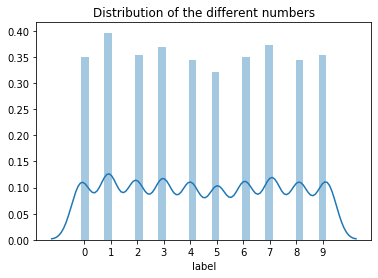

In [7]:
sns.distplot(dataset['label'])
plt.title('Distribution of the different numbers')
plt.xticks([x*0.975+0.1 for x in range(10)],[x for x in range(10)],rotation = 'horizontal')
plt.show()

Este grapho nos muestra que los numero estan en nombre comparable, no hay una categoria sobre-representada. Es importante verificar esto para que nuestro modelo no aprende estas particularidades. Es decir que queremos que nuestra modelo sea el mas general possible para que functiona el mejor possible.

In [8]:
#check for nan values 
print("Number of nan values : %d"%dataset.isnull().sum().sum())

Number of nan values : 0


The dataset is clean, no hay valores falsas.

### $\text{Ahora definemos nuestro modelo.}$

__El modelo que nos vamos a implementar es LeNet-5__

Este es el primero red neuronal convolucional conceptualizado por Yann LeCun un pionero francés en inteligencia artificial. 

Es un Graph Tranformer Network hecho por el reconocimiento de cheques bancarios. Usa redes Convolutional Neural Network character recognizers utilisando una technica de entrenamiento global. El estaba usado en la industria a leia millones de cheques cada dia con performancias mejores que las de humanos (+98% de reconovimiento)

Esta technica es : 
- muy rapida
- muy precisa
- facilmente adaptable
- mejora que otros méthodos

__Architectura global :__

- Input : 32*32 pixeles (Imagen)
- Feature extractor

   Tratando de asegurar la invariancia de cambio, escala y distorsión con dos herramientas:

    -> Covolution
 
    -> sub-sampling

     El extractor de features es una combinación piramidal de los dos.
    
- Classifier (entrenable)

   Fully connected Neural Network

- Output : 0-9 numero -> la clase que esta predictada

__Feature Extractor:__

El tiene dos componentes :
- capas de convolucion
    $f\circ g(x)=\int f^{\ast }(y)g(x+y)dy=f^{\ast }(y)\ast g(-y)$


- capas de pooling

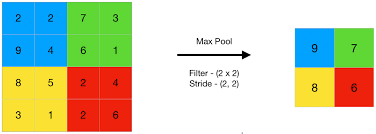

formula : $sigmoid(\frac{a+b+c+d}{4}*k+b)$


En le net se orgonisa asi:

    Convolution -> Pooling -> Convolution -> Pooling


Para mejorar la performancias, podemos usar:
- Padding(añadir pixeles al rededor de la imagen),
- Kernel sizes
- Tipo de pooling (max, average)


__Neural Network__

Este parte del modelo es para tomar las decisiones. La parte antes le da las features extraídas y con estas se va a inferir un numero.

Estos redes son muy generales y functionan bien para los planos de decisiones complicados. 

Parametros sobre cual podemos actuard:
- function de loss
- gradient descent optimizer y learning rate
- function de scoring


__Implementation__

Para implementar esto yo uso Python y Pytorch un framework muy popular entre los investigadores. Es free, open-source and  muy flexible. 

In [9]:
# Dataset responsible for manipulating data for training as well as training tests.
class DatasetMNIST(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
                
        image = item[1:].values.astype(np.uint8).reshape((28, 28))
        label = item[0].astype('long')
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label


In [10]:
batch_size = 50

trainDF, testDF = train_test_split(dataset,test_size=0.1)

transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(64),
   # transforms.RandomRotation(0, 0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])


transform_valid = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])


# Creating datasets for training and validation
train_data = DatasetMNIST(trainDF, transform=transform_train)
valid_data = DatasetMNIST(testDF, transform=transform_valid)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)

dataloaders= {'train' : train_loader, 'val' : valid_loader}#.size()

print(f"Length train: {len(train_data)}")
print(f"Length valid: {len(valid_data)}")

Length train: 37800
Length valid: 4200


### $\underline{\textbf{Defining our model}}$

<hr style="height:2px;border:none;color:#333;background-color:#333;"/>

In [16]:
14*6*6

504

In [17]:
#define the network model
class Net(nn.Module):

    '''
    Inspired but LeNet-5
    '''
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 14, kernel_size=5, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(3150, 128),
            nn.Linear(128, 10),
            nn.Dropout(p = 0.01)#dropout leads to strange results with 80+% performance when = 0.25 (when high?)
        )
        

    def forward(self, x):
        
        x = self.conv1(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


model = Net()
print(model)

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 14, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=3150, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
    (2): Dropout(p=0.01, inplace=False)
  )
)


__Configuring Model__

In [18]:
LEARNING_RATE = 0.0005

criterion = nn.CrossEntropyLoss()
#a classic stochastic gradient descent
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
#A more efficient RMSprop
#optimizer = optim.RMSprop(model.parameters(), lr = LEARNING_RATE, alpha = 0.99, eps = 1e-08)
optimizer = optim.RMSprop(model.parameters(), lr = LEARNING_RATE, alpha = 0.99, eps = 1e-08)

_Note that the choice of the optimizer has a huge inpact on the execution time_ 
### $\underline{\textbf{Model Training}}$

<hr style="height:2px;border:none;color:#333;background-color:#333;"/>

In [19]:
epochs = 3
valid_loss_min = np.Inf
train_losses, valid_losses = [], []
history_accuracy = []

for e in range(1, epochs+1):
    running_loss = 0

    for images, labels in train_loader:
        
        # Clear the gradients, do this because gradients are accumulated.
        optimizer.zero_grad()
        
        # Forward pass, get our log-probabilities.
        ps = model(images)
        # Calculate the loss with the logps and the labels.
        loss = criterion(ps, labels)
        
        # Turning loss back.
        loss.backward()
        
        # Take an update step and few the new weights.
        optimizer.step()
        
        running_loss += loss.item()
    else:
        valid_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations.
        with torch.no_grad():
            model.eval() # change the network to evaluation mode
            for images, labels in valid_loader:
                # Forward pass, get our log-probabilities.
                #log_ps = model(images)
                ps = model(images)
                
                # Calculating probabilities for each class.
                #ps = torch.exp(log_ps)
                
                # Capturing the class more likely.
                _, top_class = ps.topk(1, dim=1)
                
                # Verifying the prediction with the labels provided.
                equals = top_class == labels.view(*top_class.shape)
                
                valid_loss += criterion(ps, labels)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        model.train() # change the network to training mode
        
        train_losses.append(running_loss/len(train_loader))
        valid_losses.append(valid_loss/len(valid_loader))
        history_accuracy.append(accuracy/len(valid_loader))
        
        network_learned = valid_loss < valid_loss_min

        if e == 1 or e % 5 == 0 or network_learned:
            print(f"Epoch: {e}/{epochs}.. ",
                  f"Training Loss: {running_loss/len(train_loader):.3f}.. ",
                  f"Validation Loss: {valid_loss/len(valid_loader):.3f}.. ",
                  f"Test Accuracy: {accuracy/len(valid_loader):.3f}")
        
        if network_learned:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), 'model_mtl_mnist.pt')
            print('Detected network improvement, saving current model')

Epoch: 1/3..  Training Loss: 0.215..  Validation Loss: 0.084..  Test Accuracy: 0.972
Detected network improvement, saving current model
Epoch: 2/3..  Training Loss: 0.083..  Validation Loss: 0.063..  Test Accuracy: 0.977
Detected network improvement, saving current model
Epoch: 3/3..  Training Loss: 0.064..  Validation Loss: 0.060..  Test Accuracy: 0.980
Detected network improvement, saving current model


Esta solution funciona pero no es la mas efficiente. Lleguemos a un bueno resultado pero necessitamos muchos datos (mas que con la manera que sigue) y tiempo para hacer los calculos.

---
# Adaptive Learning

Lo que es muy practico con redes neuronales convolucionales es que son modelos muy generales. Entonces se puede usar un modelo que sirve a reconocer perros, modificarle un poquito, re-entrenarlo para nuesto caso. 

Esto processo se llama adaptive learning, nos permite ganar mucho tiempo, mejores performancias. Ademas podemos disfrutar de esto sin tener capacidades de processo muy altas.

### Defining our model

<hr style="height:2px;border:none;color:#333;background-color:#333;"/>

The model used here is the RESNET50 model. A convolutional neural network having some decent performances on the imageNet dataset.
This network is pretrained, that implies we have to adapt it to our current problem that is digit recongnition. 

The pre-training is usefull for different reasons:

- training is costly, hence we spare some time and ressources by not fully training it
- The feature exctractor part of the network is adapted to extract general features adapted to another problem, that is to say it will prevent overfitting and a better generalization.

So first we load the pre-trained model:

In [12]:
model = torch.hub.load('pytorch/vision', 'resnet50', pretrained=True)

Using cache found in /home/bastienzimmermann/.cache/torch/hub/pytorch_vision_master


Then we change the input and output layers:

- change the number of channels from 3 to one as we only have grayscale images
- change the output of the fully connected layer to match the cardinality of classes

In [13]:
#input layer
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#output layer
model.fc = nn.Linear(2048, 10)

In [14]:
model

### Model Training


_While the modeled is pre-trained, it is not trained to solve digit recognition, there still is some adaptive learning required._
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>

First off we define some usefull variables.

In [15]:
# Number of classes in the dataset
num_classes = 10

# Number of epochs to train for
num_epochs = 2

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True


is_inception = False


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)



In [16]:
since = time.time()

val_acc_history = []

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        #prepare tqdm
        if phase == 'train':
            print("Phase:",phase)
            t = tqdm(total=len(train_data)) # Initialise
            
        else:
            print("Phase:",phase)
            t = tqdm(total=len(valid_data)) # Initialise
            
        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            t.update(batch_size)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                # Get model outputs and calculate loss
                # Special case for inception because in training it has an auxiliary output. In train
                #   mode we calculate the loss by summing the final output and the auxiliary output
                #   but in testing we only consider the final output.
                if is_inception and phase == 'train':
                    # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                    outputs, aux_outputs = model(inputs)
                    loss1 = criterion(outputs, labels)
                    loss2 = criterion(aux_outputs, labels)
                    loss = loss1 + 0.4*loss2
                else:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        #close tqdm
        t.close()
        
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        if phase == 'val':
            val_acc_history.append(epoch_acc)

    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

# load best model weights
model.load_state_dict(best_model_wts)
#return model, val_acc_history


  0%|          | 0/37800 [00:00<?, ?it/s]

Epoch 0/1
----------
Phase: train


100%|██████████| 37800/37800 [56:33<00:00, 11.14it/s] 


train Loss: 0.1819 Acc: 0.9478
Phase: val


100%|██████████| 4200/4200 [01:23<00:00, 50.37it/s]


val Loss: 0.0438 Acc: 0.9871


  0%|          | 50/37800 [00:00<01:29, 423.10it/s]


Epoch 1/1
----------
Phase: train


  0%|          | 0/4200 [00:00<?, ?it/s]

train Loss: 0.0243 Acc: 0.9929
Phase: val


100%|██████████| 4200/4200 [01:02<00:00, 66.76it/s]


val Loss: 0.0335 Acc: 0.9898

Training complete in 118m 47s
Best val Acc: 0.989762


<All keys matched successfully>

## Comparar los modelos y observar donde hay errores.

In [17]:
wrongimageList = []
trueLabelList = []
wrongLabelList = []
#predict the result for the notation set
res = pd.DataFrame(columns = ['image','trueLabel','infLabel'])
wrongDF = pd.DataFrame(columns = ['image','label'])
for images, labels in valid_loader:
    ps = model(images)
    res = ps.detach().numpy()
    _, top_class = ps.topk(1, dim=1)
    falseIndexList = [i for i,x in enumerate(labels == top_class.flatten())  if x==0]
    wrongimageList = wrongimageList + [np.array(images[i]) for i in falseIndexList]
    trueLabelList = trueLabelList + [int(labels[i]) for i in falseIndexList]
    wrongLabelList = wrongLabelList + [int(top_class.flatten()[i]) for i in falseIndexList]

print("%.4f"%(100-len(wrongimageList)/len(valid_loader)), '% error rate on validation set, i.e.',len(wrongimageList),'errors')

99.4881 % error rate on validation set, i.e. 43 errors


An example digits wrongly labeled (True label - infered label):


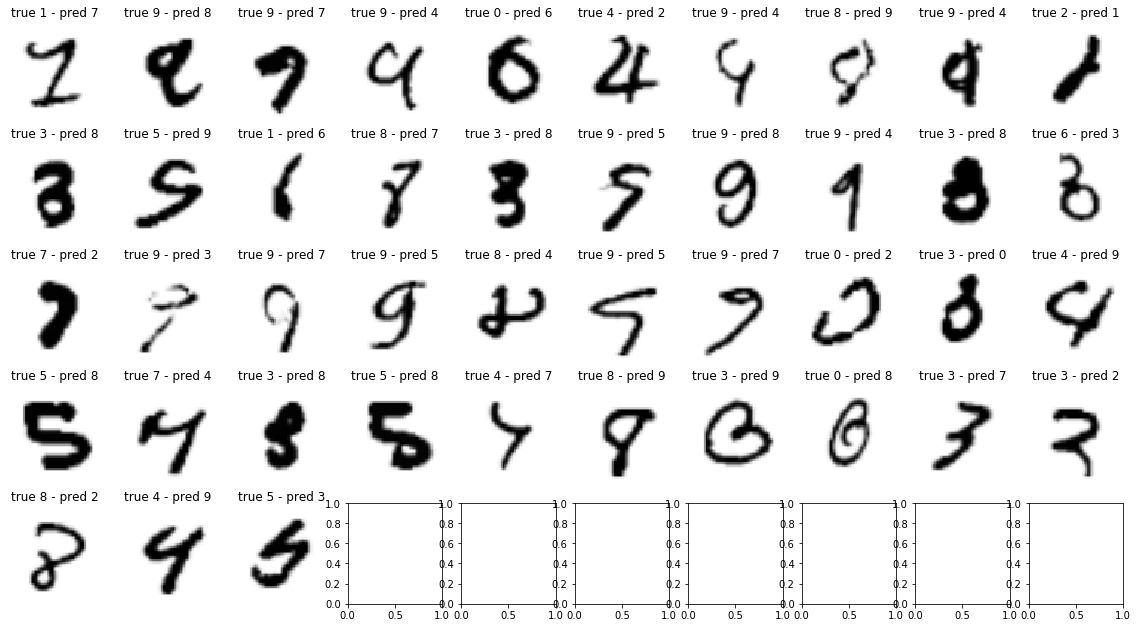

In [18]:
#print wrongly labeled digits
numRows = len(wrongimageList)//10+1
numCols = len(wrongimageList) if len(wrongimageList) < 10 else 10
fig, ax = plt.subplots(ncols = numCols,nrows = numRows, figsize = [20,len(wrongimageList)/4])
print('An example digits wrongly labeled (True label - infered label):')
for i in range(len(wrongimageList)):
    if(numRows > 1):
        currentAx = ax[i//10][i%10]
    else:
        currentAx = ax[i]
    currentAx.axis('off')
    currentAx.imshow(wrongimageList[i][0],cmap='Greys')
    currentAx.set_title("true %d"%(trueLabelList[i])+' - '+"pred %d"%(wrongLabelList[i]))

_Asi vemos que los errores son quasi humanas. En numeros casos los numeros no serian detectables por humanos._

In [19]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[404   0   1   0   0   0   1   0   1   0]
 [  0 483   0   0   0   0   1   1   0   0]
 [  0   1 431   0   0   0   0   0   0   0]
 [  1   0   1 451   0   0   0   1   4   1]
 [  0   0   1   0 377   0   0   1   0   2]
 [  0   0   0   1   0 376   0   0   2   1]
 [  0   0   0   1   0   0 412   0   0   0]
 [  0   0   1   0   1   0   0 425   0   0]
 [  0   0   1   0   1   0   0   1 402   2]
 [  0   0   0   1   4   3   0   3   2 396]]


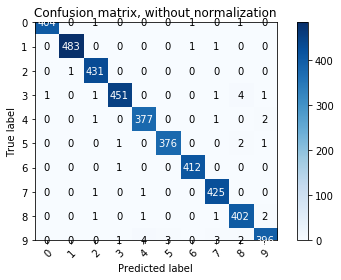

In [20]:
np.set_printoptions(precision=2)

y_test = []
y_pred = []
#predict the result for the notation set
res = pd.DataFrame(columns = ['image','trueLabel','infLabel'])
wrongDF = pd.DataFrame(columns = ['image','label'])
for images, labels in valid_loader:
    ps = model(images)
    res = ps.detach().numpy()
    _, top_class = ps.topk(1, dim=1)
    
    y_test.append(labels)
    y_pred.append(top_class.flatten())

    
y_test = np.array([np.array(x) for x in y_test]).flatten()
y_pred = np.array([np.array(x) for x in y_pred]).flatten()

    
plot_confusion_matrix(y_test, y_pred, classes=np.arange(10), normalize=False,
                      title='Confusion matrix, without normalization')


plt.show()

Con estos resultados, podemos ver que adaptive learning es mucho mejor y nos permite ganar tiempo.

---

## $\textbf{Computing results for grading set}$

---

In [22]:
notationDF = pd.read_csv('./test.csv',dtype = np.int8)

In [23]:
# Dataset responsible for manipulating data for training as well as training tests.
class DatasetMNISTNOTATION(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
                
        image = item.values.astype(np.uint8).reshape((28, 28))
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image


In [24]:
notation_data = DatasetMNISTNOTATION(notationDF, transform=transform_train)

notation_loader = torch.utils.data.DataLoader(notation_data, batch_size=1)

In [29]:
#predict the result for the notation set
resultList = []
for image in notation_loader:
    ps = model(image)
    res = ps.detach().numpy()
    resultList.append(np.argmax(res))
    

In [30]:
#write submission
finalDF = pd.DataFrame(columns = ['ImageId','Label'])
finalDF['Label'] = resultList
finalDF.index.rename('ImageId')
finalDF['ImageId'] = finalDF.index + 1
finalDF.to_csv('submissionResNetNEWBRANDASD.csv', columns = ['ImageId','Label'], index = False)

## Conclusion

Con este ejemplo de reconocimento de numeros, hemos visto como functionan los redes neuronales convolucionales. Un caso de applicacion del red entrenado es el reconocimiento de codigos postales. Correo Argentino pordría usar este para renocer seguramente y rapidamente las dirrecciónes escritas en el correo.
![title](data/reconocimentoCorreo.png)



<hr style="height:2px;border:none;color:#333;background-color:#333;"/>

Si hay una cosa qu sobrevale todo es la universinalidad de este processo. Es decir que no solo se limita a el reconocimiento de numeros pero es muy facil adaptarlo a cualquier cosa y reconecer lo que queremos en imagenes.

Por ejemplo Tesla usa estos redes con camaras para reconocer el camino, señales, personas ...  (usan Pytorch tambien)

Una empresa que tiene un problema de reconocimento bastante complicado puede resorvalos siguiendo este methodo:
- Crear un gran dataset composado de imagen -> decision
- Conceptualizar y entrenar un red neuronal convolucional con este dataset
- Usar las decisiones del red en el processo de produccion

Por ejemplo un planta de tratamiento de residuos que quiere reconocer que tipo de residuo estan y separarlos.
- sacar muchas photos de residuos indicar para cada photo el typo de residuo
- Entrenar el red neuronal convolucional con estos datos
- poner una camara que filmeo los residuos, da esta imagen al red y con el typo que indica el red actuar un mecanismo que empuje el resuduo en la buena direccíon